# Dask

<img src="images/dask_logo.jpg">

- process data that doesn't fit into memory by breaking it into blocks and specifying task chains
- parallelize execution of tasks across cores and even nodes of a cluster
- move computation to the data rather than the other way around, to minimize communication overheads

http://dask.pydata.org/en/latest/

In [ ]:
import dask
import dask.multiprocessing

## Define two slow functions

In [ ]:
from time import sleep

def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

In [ ]:
%%time
x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)

CPU times: user 703 µs, sys: 2.01 ms, total: 2.72 ms
Wall time: 3 s


## Parallelize with dask.delayed

- Functions wrapped by `dask.delayed` don't run immediately, but instead put those functions and arguments into a task graph. 
- The result is computed separately by calling the `.compute()` method.

In [ ]:
from dask import delayed

In [ ]:
x = dask.delayed(slowinc)(1)
y = dask.delayed(slowinc)(2)
z = dask.delayed(slowadd)(x, y)

In [ ]:
%%time
z.compute()

CPU times: user 11.7 ms, sys: 6.1 ms, total: 17.8 ms
Wall time: 2.01 s


5

## Dask graph

- Contains description of the calculations necessary to produce the result. 
- The z object is a lazy Delayed object. This object holds everything we need to compute the final result. We can compute the result with .compute() as above or we can visualize the task graph for this value with .visualize().

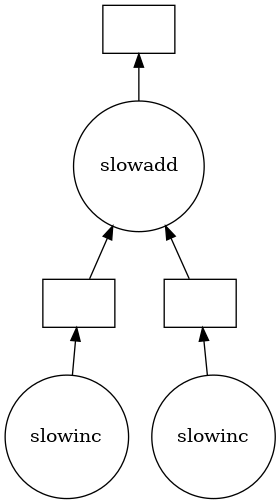

In [ ]:
z.visualize()

## Parallelize a loop

In [ ]:
%%time
data = list(range(8))

tasks = []

for x in data:
    y = delayed(slowinc)(x)
    tasks.append(y)

total = delayed(sum)(tasks)
total

CPU times: user 2.05 ms, sys: 726 µs, total: 2.78 ms
Wall time: 3.26 ms


Delayed('sum-090a3d8f-b169-4943-8915-11d46b8312d6')

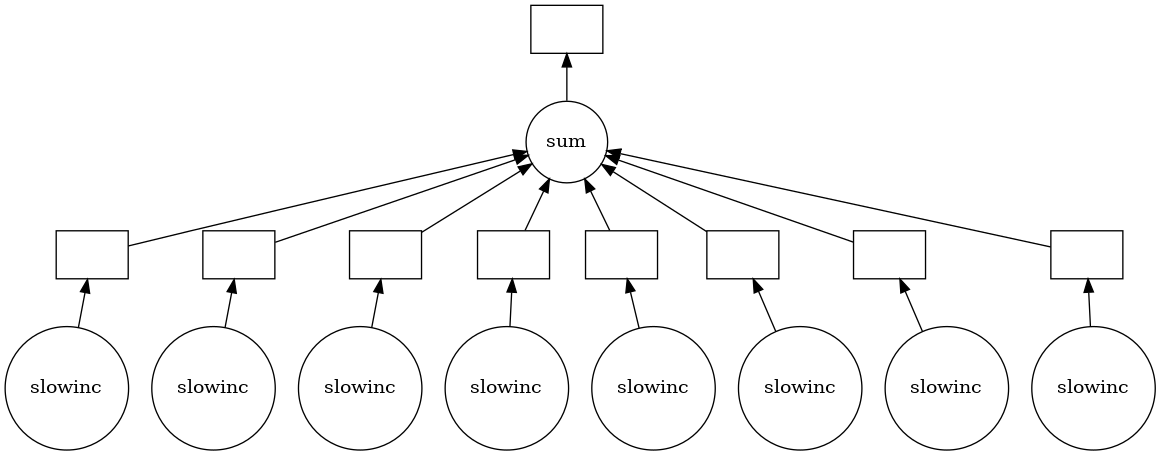

In [ ]:
total.visualize()

In [ ]:
total.compute()

36

### Exercise 8.1

- Parallelize this by appending the delayed `slowinc` calls to the list `results`.
- Display the graph of `total` computation
- Compute time elapsed for the computation.

## Decorator

It is also common to see the delayed function used as a decorator. Same example:

In [ ]:
%%time

@dask.delayed
def slowinc(x, delay=1):
    sleep(delay)
    return x + 1

@dask.delayed
def slowadd(x, y, delay=1):
    sleep(delay)
    return x + y

x = slowinc(1)
y = slowinc(2)
z = slowadd(x, y)
z.compute()

CPU times: user 5.75 ms, sys: 2.22 ms, total: 7.97 ms
Wall time: 2 s


5

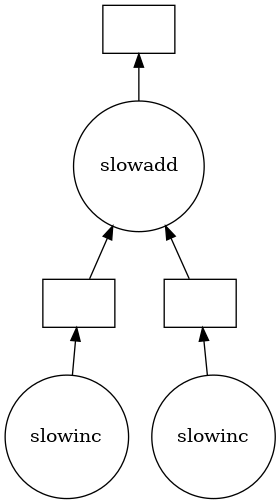

In [ ]:
z.visualize()

In [ ]:
from dataclasses import dataclass

@dataclass
class Rectangle:
    
    width : int
    height : int
    @property
    def area(self):
        return self.width * self.height

r = Rectangle( 4, 5.0)
r.area

20.0

## Control flow
-  Delay only some functions, running a few of them immediately. This is helpful when those functions are fast and help us to determine what other slower functions we should call. 
- In the example below we iterate through a list of inputs. If that input is even then we want to call `half`. If the input is odd then we want to call `odd_process`. This iseven decision to call `half` or `odd_process` has to be made immediately (not lazily) in order for our graph-building Python code to proceed.

In [ ]:
from random import randint
import dask.delayed

@delayed
def half(x):
    sleep(1)
    return x // 2

@delayed
def odd_process(x):
    sleep(1)
    return 3*x+1

def is_even(x):
    return not x % 2

data = [randint(0,100) for i in range(8)]

result = []
for x in data:
    if is_even(x):
        result.append(half(x))
    else:
        result.append(odd_process(x))

total = delayed(sum)(result)


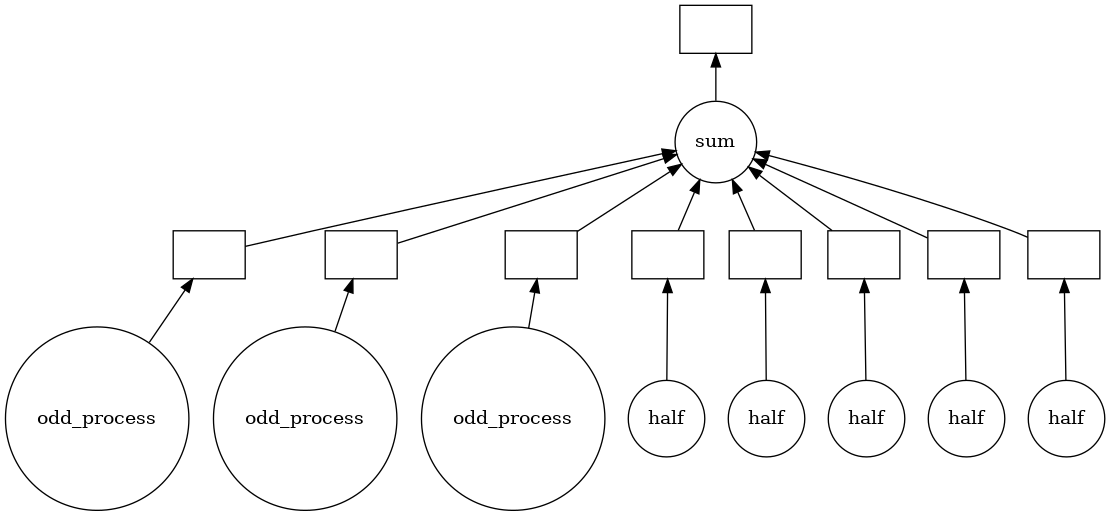

In [ ]:
total.visualize()

In [ ]:
total.compute()

465

### Exercise 8.2
- Parallelize the sequential code above using dask.delayed
- You will need to delay some functions, but not all
- Visualize and check the computed result

### Exercise 8.3
- Parallelize the hdf5 conversion from json files
- Create a function `convert_to_hdf`
- Use dask.compute function on delayed calls of the funtion created list
- Is it really  faster as expected ?

Hint: Read [Delayed Best Practices](http://dask.pydata.org/en/latest/delayed-best-practices.html)

In [ ]:
import os  # library to get directory and file paths
import tarfile # this module makes possible to read and write tar archives

def extract_data(name, where):
    datadir = os.path.join(where) # directory where extract all datafile
    if not os.path.exists(datadir): # check if this directory exists
       print("Extracting data...")
       tar_path = os.path.join(name+'.tgz')  # path to the tgz file
       with tarfile.open(tar_path, mode='r:gz') as data: # open the tgz file
          data.extractall(datadir)  # extract all data file in datadir
            
extract_data('daily-stock','data') # this function call will extract json files

In [ ]:
import dask
import os, sys
from glob import glob
import pandas as pd
import json

here = os.getcwd() # get the current directory
filenames = sorted(glob(os.path.join(here,'data', 'daily-stock', '*.json')))

In [ ]:
filenames[:5]

['/home/jovyan/work/data/daily-stock/aet.json',
 '/home/jovyan/work/data/daily-stock/afl.json',
 '/home/jovyan/work/data/daily-stock/aig.json',
 '/home/jovyan/work/data/daily-stock/al.json',
 '/home/jovyan/work/data/daily-stock/amgn.json']

In [ ]:
%rm data/daily-stock/*.h5

In [ ]:
@dask.delayed
def read( fn ):
    " read json file "
    with open(fn) as f:
        return [json.loads(line) for line in f]
    
@dask.delayed
def convert(data, fn):
    " convert json file to hdf5 file"
    df = pd.DataFrame(data)
    out_filename = fn[:-5] + '.h5'
    df.to_hdf(out_filename, '/data')
    return fn[:-5]
 
results = []
for filename in filenames:
    data = read(filename)
    results.append(convert(data, filename))
 
%time dask.compute(*results)

CPU times: user 24.4 s, sys: 5.14 s, total: 29.6 s
Wall time: 30.4 s


('/home/jovyan/work/data/daily-stock/aet',
 '/home/jovyan/work/data/daily-stock/afl',
 '/home/jovyan/work/data/daily-stock/aig',
 '/home/jovyan/work/data/daily-stock/al',
 '/home/jovyan/work/data/daily-stock/amgn',
 '/home/jovyan/work/data/daily-stock/avy',
 '/home/jovyan/work/data/daily-stock/b',
 '/home/jovyan/work/data/daily-stock/bwa',
 '/home/jovyan/work/data/daily-stock/ge',
 '/home/jovyan/work/data/daily-stock/hal',
 '/home/jovyan/work/data/daily-stock/hp',
 '/home/jovyan/work/data/daily-stock/hpq',
 '/home/jovyan/work/data/daily-stock/ibm',
 '/home/jovyan/work/data/daily-stock/jbl',
 '/home/jovyan/work/data/daily-stock/jpm',
 '/home/jovyan/work/data/daily-stock/luv',
 '/home/jovyan/work/data/daily-stock/met',
 '/home/jovyan/work/data/daily-stock/pcg',
 '/home/jovyan/work/data/daily-stock/tgt',
 '/home/jovyan/work/data/daily-stock/usb',
 '/home/jovyan/work/data/daily-stock/xom')

In [ ]:
%ls data/daily-stock/*.h5

data/daily-stock/aet.h5   data/daily-stock/bwa.h5  data/daily-stock/jpm.h5
data/daily-stock/afl.h5   data/daily-stock/ge.h5   data/daily-stock/luv.h5
data/daily-stock/aig.h5   data/daily-stock/hal.h5  data/daily-stock/met.h5
data/daily-stock/al.h5    data/daily-stock/hp.h5   data/daily-stock/pcg.h5
data/daily-stock/amgn.h5  data/daily-stock/hpq.h5  data/daily-stock/tgt.h5
data/daily-stock/avy.h5   data/daily-stock/ibm.h5  data/daily-stock/usb.h5
data/daily-stock/b.h5     data/daily-stock/jbl.h5  data/daily-stock/xom.h5


## Read multiple files with Dask Arrays

In [ ]:
from tqdm import tqdm # barre de progression
from PIL import Image # AFFICHER DES IMAGES DEPUIS UN TABLEAU 2D
import dask 
import dask.delayed as delayed
import dask.array as da
from glob import glob  # Lister des fichiers
import h5py as h5 # ecrire et lire des fichiers au format hdf5
import numpy as np # numpy pour normaliser les images

In this dataset we have two dimensional field records along time. Every h5 file contains a matrix.

Data are already downloaded in datasets directory. You can download the file from [https://github.com/MMASSD/datasets](https://github.com/MMASSD/datasets/blob/master/fvalues.tgz)

!wget https://github.com/MMASSD/datasets/raw/master/fvalues.tgz


This file is a zip archive we need to uncompress and extract.

In [ ]:
# extract_data('fvalues','.') 

You get 1000 h5 files

In [ ]:
filenames = sorted(glob("fvalues/*.h5"))
filenames[:5], len(filenames)

(['fvalues/f0001-values.h5',
  'fvalues/f0002-values.h5',
  'fvalues/f0003-values.h5',
  'fvalues/f0004-values.h5',
  'fvalues/f0005-values.h5'],
 1000)

In order to plot these fields, we will scale them between 0 to 255 grey levels.

In [ ]:
import numpy as np
def scale(x) :
    "Scale field to 0-255 levels"
    return np.uint8(255*(x-np.min(x)) / (np.max(x)-np.min(x)))

Let's create a function that read the file and return the scaled field.

In [ ]:
import h5py as h5
def read_frame( filepath ):
    " Create image from the `dataset` of h5 file `filepath` "
    with h5.File(filepath, "r") as f:
        z = f.get("values")
        return scale(z)

In [ ]:
image = read_frame( filenames[0])
image.shape

(257, 257)

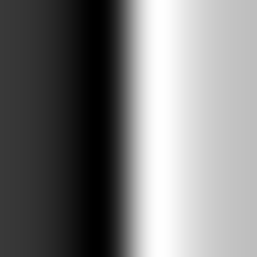

In [ ]:
from PIL import Image 
Image.fromarray(image)

With NumPy we might allocate a big array and then iteratively load images and place them into this array `serial_frames`.

In [ ]:
%%time
serial_frames = np.empty((1000,*image.shape), dtype=np.uint8)
for i, fn in enumerate(filenames):
    serial_frames[i, :, :] = read_frame(fn)

CPU times: user 4.47 s, sys: 2.57 s, total: 7.04 s
Wall time: 11.7 s


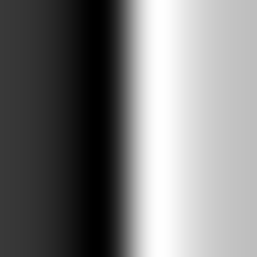

In [ ]:
from ipywidgets import interact, IntSlider
 
def display_sequence(iframe):
     return Image.fromarray(serial_frames[iframe,:,:])
     
interact(display_sequence, 
          iframe=IntSlider(min=0,
                           max=np.shape(serial_frames)[0]-1,
                           step=1,
                           value=0, 
                           continuous_update=True));

In the code above, we read all images and store them in memory. If you have more plots or bigger images it won't fit in your computer memory. You have two options:
- Use a bigger computer
- Not store all files in memory and read only the file that contains the field you want to display.

## Use dask to read and display images

We can delayed the read function

In [ ]:
lazy_read = delayed(read_frame)
lazy_frames = [lazy_read(fn) for fn in filenames]

Instead of `serial_frames`, we create an array of delayed tasks.

In [ ]:
import dask.array as da
lazy_frames = [da.from_delayed(lazy_read,# Construct a small Dask array
                           dtype=image.dtype,   # for every lazy value
                           shape=image.shape)
          for lazy_read in lazy_frames]
lazy_frames[0]

dask.array<from-value, shape=(257, 257), dtype=uint8, chunksize=(257, 257), chunktype=numpy.ndarray>

In [ ]:
dask_frames = da.stack(lazy_frames[:100], axis=0)  # concatenate arrays along first axis 

In [ ]:
dask_frames 

dask.array<stack, shape=(100, 257, 257), dtype=uint8, chunksize=(1, 257, 257), chunktype=numpy.ndarray>

In [ ]:
dask_frames = dask_frames.rechunk((10, 257, 257))   
dask_frames

dask.array<rechunk-merge, shape=(100, 257, 257), dtype=uint8, chunksize=(10, 257, 257), chunktype=numpy.ndarray>

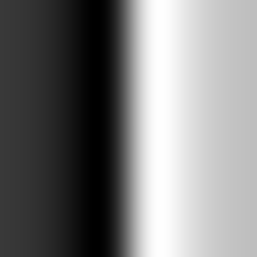

In [ ]:
Image.fromarray(scale(dask_frames.mean(axis=0).compute()))

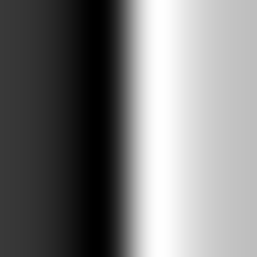

<function __main__.display_sequence(iframe)>

In [ ]:
from ipywidgets import interact, IntSlider
 
def display_sequence(iframe):
     
     return Image.fromarray(dask_frames[iframe,:,:].compute())
     
interact(display_sequence, 
          iframe=IntSlider(min=0,
                           max=len(dask_frames)-1,
                           step=1,
                           value=0, 
                           continuous_update=True))

Everytime you move the slider, it will read the corresponding file and load the frame. That's why you need to wait a little to get your image. You load image one by one and you can handle a very large amount of images.

### Some questions to consider:

-  Why did we go from 3s to 2s?  Why weren't we able to parallelize down to 1s?
-  What would have happened if the inc and add functions didn't include the `sleep(1)`?  Would Dask still be able to speed up this code?
-  What if we have multiple outputs or also want to get access to x or y?

## Exercise: Parallelizing a Pandas Groupby Reduction

In this exercise we read several CSV files and perform a groupby operation in parallel.  We are given sequential code to do this and parallelize it with `dask.delayed`.

The computation we will parallelize is to compute the mean departure delay per airport from some historical flight data.  We will do this by using `dask.delayed` together with `pandas`.  In a future section we will do this same exercise with `dask.dataframe`.

### Prep data

First, run this code to prep some data.  You don't need to understand this code.

This extracts some historical flight data for flights out of NYC between 1990 and 2000. The data is taken from [here](http://stat-computing.org/dataexpo/2009/the-data.html). This should only take a few seconds to run.

### Inspect data

Data are in the file `data/nycflights.tar.gz`. You can extract them with the command
```bash
tar zxvf nycflights.tar.gz
```
According to your operating system, double click on the file could do the job.

In [ ]:
#import os  # library to get directory and file paths
#import tarfile # this module makes possible to read and write tar archives
#
#def extract_data(filename, where):
#    datadir = os.path.join(where) # directory where extract all datafile
#    if not os.path.exists(datadir): # check if this directory exists
#       print("Extracting data...")
#       tar_path = os.path.join(filename)  # path to the tgz file
#       with tarfile.open(tar_path, mode='r:gz') as data: # open the tgz file
#          data.extractall(datadir)  # extract all data file in datadir
#            
#extract_data('data/nycflights.tar.gz','data')

### Read one file with `pandas.read_csv` and compute mean departure delay

In [ ]:
import pandas as pd
df = pd.read_csv(os.path.join("data", "nycflights",'1990.csv'))
df.head()

,Year,Month,DayofMonth,DayOfWeek,DepTime,CRSDepTime,ArrTime,CRSArrTime,UniqueCarrier,FlightNum,...,AirTime,ArrDelay,DepDelay,Origin,Dest,Distance,TaxiIn,TaxiOut,Cancelled,Diverted
0,1990,1,1,1,1621.0,1540,1747.0,1701,US,33,...,NaN,46.0,41.0,EWR,PIT,319.0,NaN,NaN,0,0
1,1990,1,2,2,1547.0,1540,1700.0,1701,US,33,...,NaN,-1.0,7.0,EWR,PIT,319.0,NaN,NaN,0,0
2,1990,1,3,3,1546.0,1540,1710.0,1701,US,33,...,NaN,9.0,6.0,EWR,PIT,319.0,NaN,NaN,0,0
3,1990,1,4,4,1542.0,1540,1710.0,1701,US,33,...,NaN,9.0,2.0,EWR,PIT,319.0,NaN,NaN,0,0
4,1990,1,5,5,1549.0,1540,1706.0,1701,US,33,...,NaN,5.0,9.0,EWR,PIT,319.0,NaN,NaN,0,0


In [ ]:
# What is the schema?
df.dtypes

Year                   int64
Month                  int64
DayofMonth             int64
DayOfWeek              int64
DepTime              float64
CRSDepTime             int64
ArrTime              float64
CRSArrTime             int64
UniqueCarrier         object
FlightNum              int64
TailNum              float64
ActualElapsedTime    float64
CRSElapsedTime         int64
AirTime              float64
ArrDelay             float64
DepDelay             float64
Origin                object
Dest                  object
Distance             float64
TaxiIn               float64
TaxiOut              float64
Cancelled              int64
Diverted               int64
dtype: object

In [ ]:
# What originating airports are in the data?
df.Origin.unique()

array(['EWR', 'LGA', 'JFK'], dtype=object)

In [ ]:
# Mean departure delay per-airport for one year
df.groupby('Origin').DepDelay.mean()

Origin
EWR     9.168411
JFK    11.857274
LGA     8.560045
Name: DepDelay, dtype: float64

### Sequential code: Mean Departure Delay Per Airport

The above cell computes the mean departure delay per-airport for one year. Here we expand that to all years using a sequential for loop.

In [ ]:
from glob import glob
filenames = sorted(glob(os.path.join('data', "nycflights", '*.csv')))
filenames

['data/nycflights/1990.csv',
 'data/nycflights/1991.csv',
 'data/nycflights/1992.csv',
 'data/nycflights/1993.csv',
 'data/nycflights/1994.csv',
 'data/nycflights/1995.csv',
 'data/nycflights/1996.csv',
 'data/nycflights/1997.csv',
 'data/nycflights/1998.csv',
 'data/nycflights/1999.csv']

In [ ]:
%%time

sums = []
counts = []
for fn in filenames:
    # Read in file
    df = pd.read_csv(fn)
    
    # Groupby origin airport
    by_origin = df.groupby('Origin')
    
    # Sum of all departure delays by origin
    total = by_origin.DepDelay.sum()
    
    # Number of flights by origin
    count = by_origin.DepDelay.count()
    
    # Save the intermediates
    sums.append(total)
    counts.append(count)

# Combine intermediates to get total mean-delay-per-origin
total_delays = sum(sums)
n_flights = sum(counts)
mean = total_delays / n_flights

CPU times: user 7.89 s, sys: 1.88 s, total: 9.77 s
Wall time: 9.92 s


In [ ]:
mean

Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

### Exercise : Parallelize the code above

Use `dask.delayed` to parallelize the code above.  Some extra things you will need to know.

1.  Methods and attribute access on delayed objects work automatically, so if you have a delayed object you can perform normal arithmetic, slicing, and method calls on it and it will produce the correct delayed calls.

    ```python
    x = delayed(np.arange)(10)
    y = (x + 1)[::2].sum()  # everything here was delayed
    ```
2.  Calling the `.compute()` method works well when you have a single output.  When you have multiple outputs you might want to use the `dask.compute` function:

    ```python
    >>> x = delayed(np.arange)(10)
    >>> y = x ** 2
    >>> min, max = compute(y.min(), y.max())
    (0, 81)
    ```
    
    This way Dask can share the intermediate values (like `y = x**2`)
    
So your goal is to parallelize the code above (which has been copied below) using `dask.delayed`.  You may also want to visualize a bit of the computation to see if you're doing it correctly.

In [ ]:
%%time
from dask import delayed, compute
from operator import add
from functools import reduce

sums = []
counts = []

@delayed
def read_depdelay(fn):
    # Read in file
    df = pd.read_csv(fn)
    DepDelay = df.groupby('Origin').DepDelay
    return DepDelay.sum(), DepDelay.count()

@delayed
def compute_mean( list_of_tuples ):
    totals = 0
    counts = 0
    for t, c in list_of_tuples:
        totals += t
        counts += c
    return totals / counts
    
totals_and_counts = [read_depdelay(fn) for fn in filenames]

result = compute_mean(totals_and_counts)

result.compute()

CPU times: user 9.49 s, sys: 2.13 s, total: 11.6 s
Wall time: 8.01 s


Origin
EWR    10.295469
JFK    10.351299
LGA     7.431142
Name: DepDelay, dtype: float64

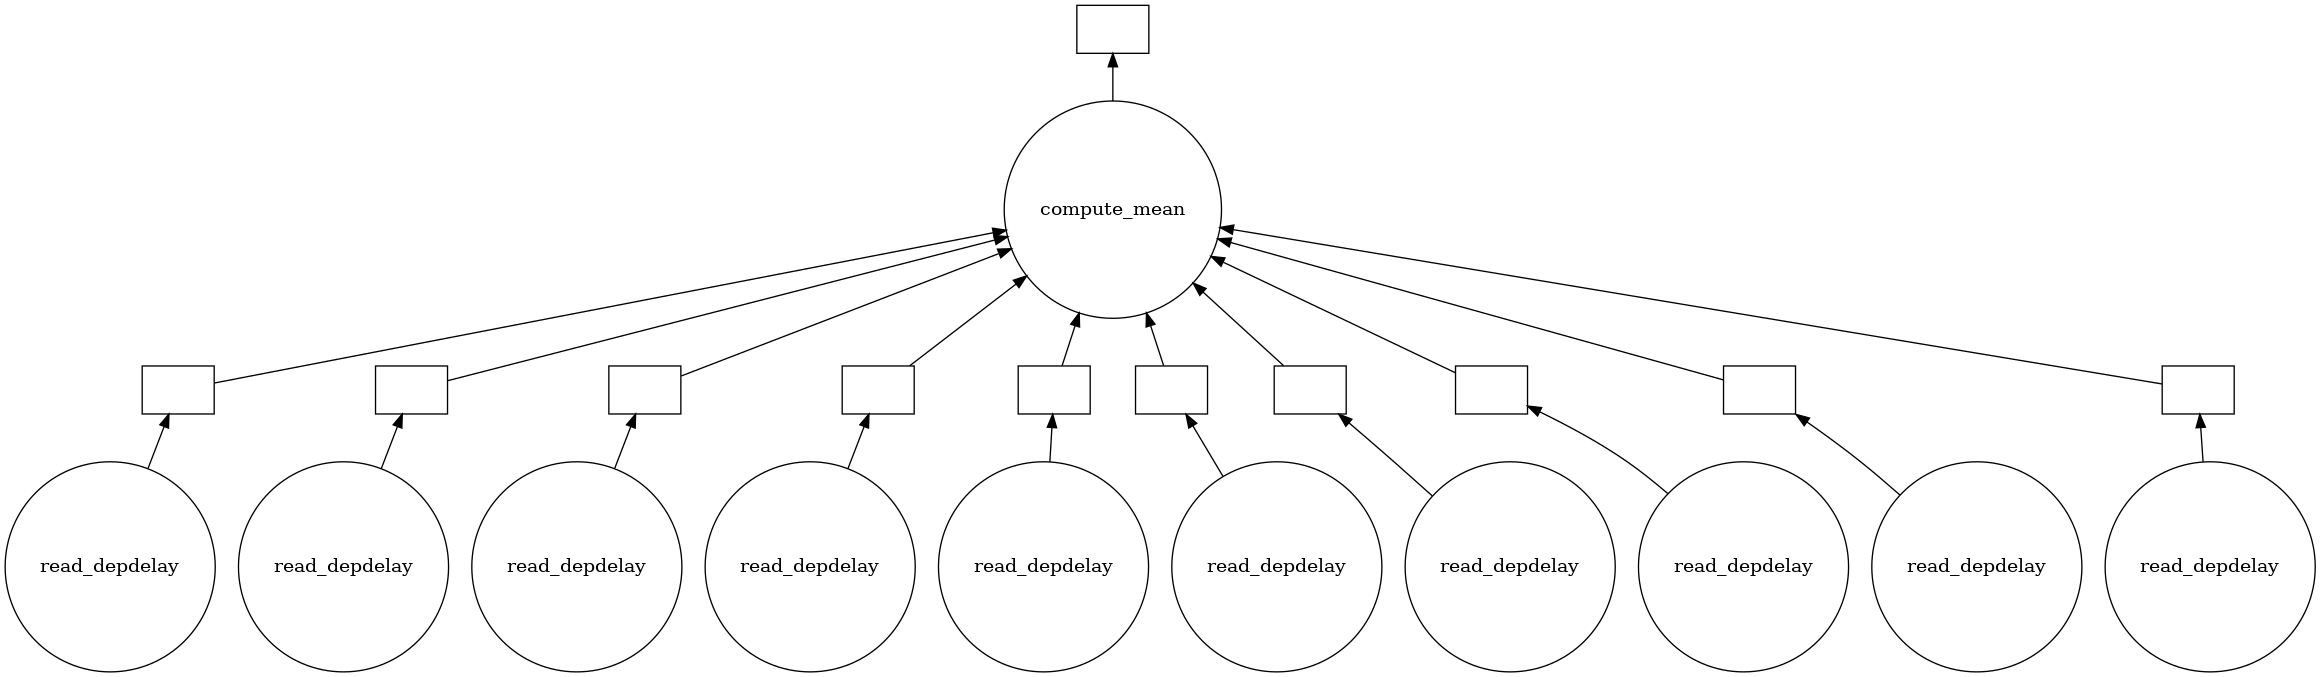

In [ ]:
result.visualize()

[Delayed best practices](https://docs.dask.org/en/latest/delayed-best-practices.html)